## Exploratory data analysis
This notebook will explore the dataset of instacart. 

### Step 01: Load data and quick sanity check
Goal : Make wue have the right columns + sizes + no obvious corruptions.

In [23]:
import os
import pandas as pd

# notebook is in: project_root/notebooks
PROJECT_ROOT = os.path.abspath("..")

INTERIM_DIR = os.path.join(PROJECT_ROOT, "data", "interim")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

os.makedirs(PROCESSED_DIR, exist_ok=True)

orders = pd.read_parquet(os.path.join(INTERIM_DIR, "orders.parquet"))
op = pd.read_parquet(os.path.join(INTERIM_DIR, "order_products.parquet"))
products = pd.read_parquet(os.path.join(INTERIM_DIR, "products.parquet"))
aisles = pd.read_parquet(os.path.join(INTERIM_DIR, "aisles.parquet"))
departments = pd.read_parquet(os.path.join(INTERIM_DIR, "departments.parquet"))


print("Loaded interim data ⏳")
print("orders_df:", orders.shape)
print("order_products_df:", op.shape)
print("products_df:", products.shape)
print("aisles_df:", aisles.shape)
print("departments_df:", departments.shape)
print("✅ All interim data loaded successfully")
# The head of orders dataset
print(orders.head())
" The head of order_products dataset"
print(op.head())    

Loaded interim data ⏳
orders_df: (3421083, 7)
order_products_df: (33819106, 4)
products_df: (49688, 4)
aisles_df: (134, 2)
departments_df: (21, 2)
✅ All interim data loaded successfully
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        93

__What we conclude__: 
dataset scale, confirm key fields exist:

orders: `order_id`, `user_id`, `order_number`, `days_since_prior_order`

order products: `order_id`, `product_id`, `add_to_cart_order`, `reordered`

### Step 01: Check uniqueness + keys (data quality)

Goal: Ensure joins won't duplicate or lose data

In [24]:
# Uniqueness checks
assert orders["order_id"].is_unique, "orders.order_id should be unique"
assert products["product_id"].is_unique, "products.product_id should be unique"
assert aisles["aisle_id"].is_unique, "aisles.aisle_id should be unique"
assert departments["department_id"].is_unique, "departments.department_id should be unique"

# Null checks
print("orders nulls:")
print(orders.isna().mean().sort_values(ascending=False).head(10))
print("\norder_products nulls:")
print(op.isna().mean().sort_values(ascending=False).head(10))

orders nulls:
days_since_prior_order    0.060276
user_id                   0.000000
order_id                  0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
dtype: float64

order_products nulls:
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64


__What we conclude:__

`days_since_prior_order` is expected to be null for first orders.

Other IDs should not be null.

### Step 02: Understand the entity relationships (the “aisle ↔ department” confusion)

__Reality:__ Instacart structure is:

* `products` → has `aisle_id` and `department_id`

* `aisles` → describes `aisle_id`

* `departments` → describes `department_id`

So __aisles don’t map 1-to-1 to departments globally__; many products in an aisle can belong to one department, but the safest truth is: __the product is the bridge.__

Check it:

In [25]:
prod_enriched = products.merge(aisles, on="aisle_id", how="left") \
                        .merge(departments, on="department_id", how="left")

# Are there aisles with multiple departments (via products)?
aisle_dept_counts = prod_enriched.groupby("aisle_id")["department_id"].nunique().sort_values(ascending=False)
aisle_dept_counts.head(10)

aisle_id
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: department_id, dtype: int64

__What we conclude:__

If `nunique()` > 1 for some aisles, we must not force an aisle→department mapping directly, or we'll lose products / mislabel.

### Step 3 — Join orders + items + products and do a “sanity completeness check”

__Goal:__ after joining, ensure no order lines got dropped.

In [26]:
op0 = op.shape[0]

df = op.merge(orders, on="order_id", how="left")
assert df["user_id"].isna().sum() == 0, "Some order_id in op not found in orders!"

df = df.merge(products[["product_id","aisle_id","department_id"]], on="product_id", how="left")
assert df["aisle_id"].isna().sum() == 0, "Some product_id in op not found in products!"
assert df.shape[0] == op0, "Join changed number of rows (duplication or loss)!"

df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,17,13


__What to conclude:__

* We didn’t lose any order-product rows.

* We can trust this table for EDA + modeling.

### Step 4 — Explore user/order behavior (time & repetition)

This is the foundation for predictive association rules.

#### 4A) Orders per user

In [27]:
user_orders = orders.groupby("user_id")["order_number"].max()
user_orders.describe(percentiles=[.5,.75,.9,.95,.99])

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
50%          10.000000
75%          20.000000
90%          38.000000
95%          52.000000
99%          89.000000
max         100.000000
Name: order_number, dtype: float64

__Conclude:__

Do we have enough repeat history?

If many users have only 1–2 orders, predictive evaluation becomes tricky (cold start).

#### 4B) Time gaps

In [28]:
orders["days_since_prior_order"].describe()
orders["days_since_prior_order"].value_counts(dropna=False).head(10)

days_since_prior_order
30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
NaN     206209
2.0     193206
8.0     181717
1.0     145247
Name: count, dtype: int64

__Conclude:__

* Shopping frequency patterns (weekly-ish, etc.)

* First orders have NaN gaps (normal)

### Step 5 — Basket characteristics (how baskets look)
#### 5A) Basket size distribution (items per order)

In [29]:
basket_size = op.groupby("order_id")["product_id"].count()
basket_size.describe(percentiles=[.5,.75,.9,.95,.99])

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
50%      8.000000e+00
75%      1.400000e+01
90%      2.000000e+01
95%      2.500000e+01
99%      3.500000e+01
max      1.450000e+02
Name: product_id, dtype: float64

Optional plot

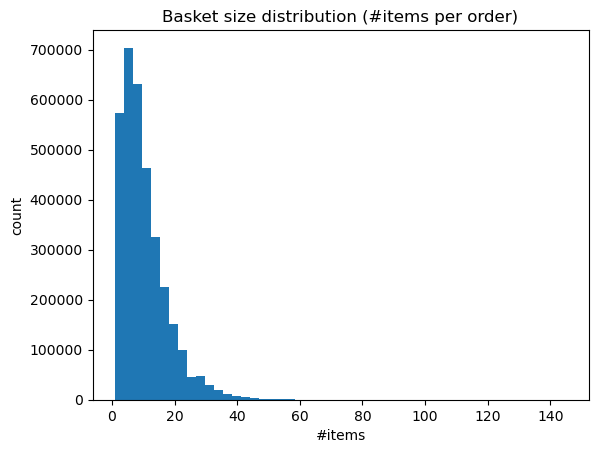

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(basket_size, bins=50)
plt.title("Basket size distribution (#items per order)")
plt.xlabel("#items")
plt.ylabel("count")
plt.show()

__Conclude:__

* Typical basket sizes

* Outliers (very large baskets)

* Helps choose evaluation metric and computational strategy.

#### 5B) Reorder rate

In [31]:
op["reordered"].mean(), op["reordered"].value_counts(normalize=True)

(np.float64(0.5900617242809434),
 reordered
 1    0.590062
 0    0.409938
 Name: proportion, dtype: float64)

reorder once = 1 is 59% while orders without reorder is 41% 

__Conclude:__
* Instacart has strong repetition → good for next-basket prediction.

### Step 6 — Product frequency + long tail

__Goal:__ see if product purchases are extremely skewed (they usually are).


In [32]:
prod_freq = op["product_id"].value_counts()
prod_freq.describe(percentiles=[.5,.75,.9,.95,.99])

count     49685.000000
mean        680.670343
std        4987.769425
min           1.000000
50%          63.000000
75%         272.000000
90%        1066.000000
95%        2382.600000
99%       10375.800000
max      491291.000000
Name: count, dtype: float64

Optional: “coverage” curve (how many products explain X% of purchases):

In [33]:
cum = (prod_freq / prod_freq.sum()).cumsum()
cum[cum <= 0.5].shape[0], cum[cum <= 0.8].shape[0], cum[cum <= 0.9].shape[0]

(789, 4558, 9191)

__Conclude:__

If heavy long tail: rules will be dominated by frequent staples unless you filter or do category-level rules too.

### Step 7 — Temporal leakage check (the key “future can’t predict past” point)

Even before doing predictive AR, verify chronology is usable.

__For each user:__ last order number is their “future”.

In [34]:
orders_sorted = orders.sort_values(["user_id","order_number"])
last_order_per_user = orders_sorted.groupby("user_id").tail(1)[["user_id","order_id","order_number"]]
last_order_per_user.head()

,user_id,order_id,order_number
10,1,1187899,11
25,2,1492625,15
38,3,2774568,13
44,4,329954,6
49,5,2196797,5


__Conclude:__

You can create a per-user split: “all but last” vs “last”.

### Step 8 — Build “predictive-ready” datasets (without mining yet)

This step creates the train/test split correctly, but we still haven’t mined rules.

#### 8A) Train = orders before the last order (per user)
#### 8B) Test = last order (per user)

In [35]:
# Identify last order_id per user
last_orders = orders_sorted.groupby("user_id").tail(1)[["user_id","order_id"]].rename(columns={"order_id":"test_order_id"})

# Mark each order as train/test
orders_tagged = orders.merge(last_orders, on="user_id", how="left")
orders_tagged["is_test"] = orders_tagged["order_id"] == orders_tagged["test_order_id"]

train_orders = orders_tagged.loc[~orders_tagged["is_test"], "order_id"]
test_orders  = orders_tagged.loc[ orders_tagged["is_test"], "order_id"]

op_train = op[op["order_id"].isin(train_orders)]
op_test  = op[op["order_id"].isin(test_orders)]

op_train.shape, op_test.shape

((32434489, 4), (1384617, 4))

### Step 9 — “Small random chunk gives same results?” (EDA version)

Before mining rules, we check whether sampling is representative.

Sample 10–20% of train orders and compare basket size & top products.

In [36]:
import numpy as np

rng = np.random.default_rng(42)
train_order_ids = train_orders.values
sample_ids = rng.choice(train_order_ids, size=int(0.2 * len(train_order_ids)), replace=False)

op_train_sample = op_train[op_train["order_id"].isin(sample_ids)]

# Compare basket sizes
bs_full = op_train.groupby("order_id")["product_id"].count()
bs_samp = op_train_sample.groupby("order_id")["product_id"].count()

bs_full.describe(), bs_samp.describe()

(count    3.214874e+06
 mean     1.008888e+01
 std      7.525398e+00
 min      1.000000e+00
 25%      5.000000e+00
 50%      8.000000e+00
 75%      1.400000e+01
 max      1.450000e+02
 Name: product_id, dtype: float64,
 count    642974.000000
 mean         10.092781
 std           7.520747
 min           1.000000
 25%           5.000000
 50%           8.000000
 75%          14.000000
 max         145.000000
 Name: product_id, dtype: float64)

Compare top products overlap:

In [37]:
top_full = set(op_train["product_id"].value_counts().head(200).index)
top_samp = set(op_train_sample["product_id"].value_counts().head(200).index)

overlap = len(top_full & top_samp) / len(top_full)
overlap

0.985

__Conclude:__

If basket size stats and top-product overlap are close → sampling is safe for faster experiments.